In [ ]:
# LIBRERIAS COLAB - SOLO COLAB
!pip install pydrive
from google.colab.patches import cv2_imshow
import sys
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# SOLO COLAB para leer una ruta
data = []
#Crear lista con las fotos (CAMBIAR CARPETA A LA QUE SE QUIERA VER)
folder_id = '1vD2Ay828QIlsg87DJ7lOhyyX5WntL6PX'
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Crear un directorio local
local_folder = '/content/Marcha'
os.makedirs(local_folder, exist_ok=True)

# Extension de imagenes
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

for file in file_list:
    # Obtener la extensión del archivo
    _, extension = os.path.splitext(file['title'])
    extension = extension.lower()

    # Verificar si la extensión es una extensión de imagen
    if extension in image_extensions:
        file.GetContentFile(os.path.join(local_folder, file['title']))


In [ ]:
# SOLO COLAB para leer una ruta (MODELO SKLEARN)

#Lista con archivos joblib
folder_id = '1FARWerlsPc93gKJtSAK_HPff2ydBhzCL'
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Crear un directorio local
local_folder = '/content/'
os.makedirs(local_folder, exist_ok=True)

# Extension de scaler y modelo
extensions = {'.joblib'}

for file in file_list:
    # Obtener la extensión del archivo
    _, extension = os.path.splitext(file['title'])
    extension = extension.lower()

    # Verificar si la extensión es correcta
    if extension in extensions:
        file.GetContentFile(os.path.join(local_folder, file['title']))

In [ ]:
!pip install mediapipe opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [ ]:
# LIBRERIAS USADAS
import cv2
import mediapipe as mp
import numpy as np

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [ ]:
# IMPORTAR MODELO:
from joblib import load
model = load('modelo_entrenado.joblib')
scaler = load('scaler.joblib')

In [ ]:
# FUNCION PARA CALCULAR ANGULO Y CENTRO
def angle(a, b, c):
    """
    Calcula el ángulo entre tres puntos dados (a, b, c) utilizando el producto punto.
    """
    # Se convierten los puntos a arreglos de numpy
    a = np.array(a)  # Punto de la cadera
    b = np.array(b)  # Punto de la rodilla
    c = np.array(c)  # Punto del tobillo

    a = np.multiply(tuple(a), [W, H]).astype(int)
    b = np.multiply(tuple(b), [W, H]).astype(int)
    c = np.multiply(tuple(c), [W, H]).astype(int)

    #Se calculan los vectores desde el punto medio hacia los puntos inicial y final
    ba = a - b
    bc = c - b

    # Se calcula el ángulo utilizando el producto punto y la magnitud de los vectores
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    # Se asegura que el valor esté en el rango válido para arccos con np.clip
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)

    # Se calcula el ángulo en grados
    angle = np.degrees(np.arccos(cosine_angle))

    if angle > 180:
      angle = angle-180
    if angle < 90:
      angle = 180 - angle

    angle = abs(round(angle))

    data = [angle, b]
    return data

In [ ]:
# DEFINIR VARIABLES

# Para la posición de partes del cuerpo:
# Nariz
N = [0,0]
# Hombro Izquierdo, Cadera Izquierda, Rodilla Izquierda, TObillo Izquierdo, TAlon Izquierdo
H_I, C_I, R_I, TO_I, TA_I = [0,0],[0,0],[0,0],[0,0],[0,0]
# Hombro Derecho, Cadera Derecha, Rodilla Derecha, TObillo Derecho, TAlon Derecho
H_D, C_D, R_D, TO_D, TA_D = [0,0],[0,0],[0,0],[0,0],[0,0]

# Para la información: (Datos Cadera Izquierda)
DCI, DRI, DTOI = 0, 0, 0
DCD, DRD, DTOD = 0, 0, 0
# Cada uno tiene el angulo, la posicion y los angulos para dibujar el elipse

# Colores para la detección: (Color Lineas, Color puntos)
CL = (130,140,40)
CP = (205,218,56)

# Para los colores de cada parte: (Color Cadera Izquierda)
CCI, CRI, CTOI = (30,180,200), (30,120,200), (30,60,200)
CCD, CRD, CTOD = (200,180,30), (200,120,30), (200,60,30)

In [ ]:
# Escoger los angulos del lado que queremos ver:
I = 1 # Miembro izquierdo
D = 1 # Miembro derecho

In [ ]:
path = 'Marcha/BD_P3_Final.png' # Para leer en colab

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


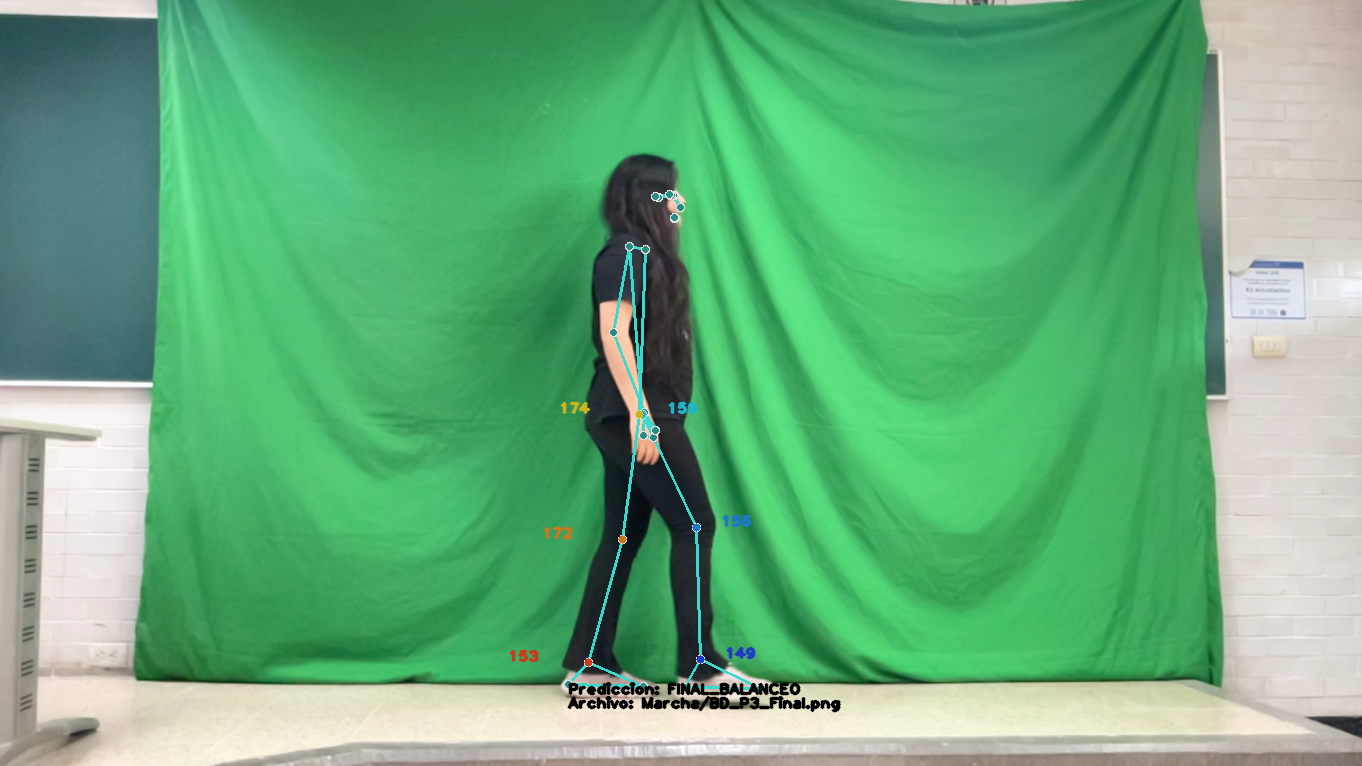

In [ ]:
with mp_pose.Pose(static_image_mode = True, model_complexity = 2, min_detection_confidence = 0.5) as pose:

    # Leemos la imagen y obtenemos sus caracteristicas
    image = cv2.imread(path)
    H, W, channels = image.shape
    # Correciones para el texto y gráfica (Corrección X izquierdo y derecho):
    CXI, CXD = round(W/55), -round(W/17)
    # Correcciones para las graficas, TE = Tamaño elipse, t1 y t2 para Tamaño texto y grosor general
    TE = round(W/64)
    T1 = round(W/1000)
    T2 = T1 + 1

    # Cambiamos los colores para mediapipe
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False #Ahorra memoria cuando procesemos
    # Hacemos la detección
    results = pose.process(image)
    # Regresamos a los canales BGR
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)

    # Extrayendo los marcadores
    try:
        landmarks = results.pose_landmarks.landmark
        # Las coordenadas de los puntos que usaremos
        N = [landmarks[0].x,landmarks[0].y]
        H_I, H_D = [landmarks[11].x,landmarks[11].y],[landmarks[12].x,landmarks[12].y]
        C_I, C_D = [landmarks[23].x,landmarks[23].y],[landmarks[24].x,landmarks[24].y]
        R_I, R_D = [landmarks[25].x,landmarks[25].y],[landmarks[26].x,landmarks[26].y]
        TO_I, TO_D = [landmarks[27].x,landmarks[27].y],[landmarks[28].x,landmarks[28].y]
        TA_I, TA_D = [landmarks[29].x,landmarks[29].y],[landmarks[30].x,landmarks[30].y]

        # Graficamos detecciones
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(CL, thickness = T2, circle_radius = T2),
                                  mp_drawing.DrawingSpec(CP, thickness = T2, circle_radius = T2))

        # Visualizamos angulos
        if D == 1 and C_D[1] <= 1 and R_D[1] <= 1 and TO_D[1] <= 1:

            # Calcular información correspondiente
            DCD = angle(H_D, C_D, R_D)
            DRD = angle(C_D, R_D, TO_D)
            DTOD = angle(R_D, TO_D, TA_D)


            '''
            # Graficar angulos para cada arco
            dibujar_arco(image, DCD, N, TE, CCD, T2) # Hombro, cadera, rodilla, nariz, tamaño elipse, color cadera, Thickness 2
            dibujar_arco(image, DRD, N, TE, CRD, T2)
            dibujar_arco(image, DTOD, N, TE, CTOD, T2)
            '''

            # Graficar los puntos de cadera, rodilla y talón
            cv2.circle(image,DCD[1],T2*2,CCD,-1)
            cv2.circle(image,DRD[1],T2*2,CRD,-1)
            cv2.circle(image,DTOD[1],T2*2,CTOD,-1)

            # Graficar los textos con los angulos correspondientes
            cv2.putText(image,str(DCD[0]), np.array(DCD[1])+np.array([CXI,-1]), cv2.FONT_HERSHEY_PLAIN, T1, CCD, T2,cv2.LINE_AA)
            cv2.putText(image,str(DRD[0]), np.array(DRD[1])+np.array([CXI,-1]), cv2.FONT_HERSHEY_PLAIN, T1, CRD, T2,cv2.LINE_AA)
            cv2.putText(image,str(DTOD[0]), np.array(DTOD[1])+np.array([CXI,-1]),cv2.FONT_HERSHEY_PLAIN, T1, CTOD, T2,cv2.LINE_AA)

        if I == 1 and C_I[1] <= 1 and R_I[1] <= 1 and TO_I[1] <= 1:

            # Calcular información correspondiente
            DCI = angle(H_I, C_I, R_I)
            DRI = angle(C_I, R_I, TO_I)
            DTOI = angle(R_I, TO_I, TA_I)


            '''
            # Graficar angulos para cada arco
            dibujar_arco(image, DCI, N, TE, CCI, T2) # Hombro, cadera, rodilla, nariz, tamaño elipse, color cadera, Thickness 2
            dibujar_arco(image, DRI, N, TE, CRI, T2)
            dibujar_arco(image, DTOI, N, TE, CTOI, T2)
            '''
            # Graficar los puntos de cadera, rodilla y talón
            cv2.circle(image,DCI[1],T2*2,CCI,-1)
            cv2.circle(image,DRI[1],T2*2,CRI,-1)
            cv2.circle(image,DTOI[1],T2*2,CTOI,-1)

            # Graficar los textos con los angulos correspondientes
            cv2.putText(image,str(DCI[0]), np.array(DCI[1])+np.array([CXD,-1]), cv2.FONT_HERSHEY_PLAIN, T1, CCI, T2,cv2.LINE_AA)
            cv2.putText(image,str(DRI[0]), np.array(DRI[1])+np.array([CXD,-1]), cv2.FONT_HERSHEY_PLAIN, T1, CRI, T2,cv2.LINE_AA)
            cv2.putText(image,str(DTOI[0]), np.array(DTOI[1])+np.array([CXD,-1]),cv2.FONT_HERSHEY_PLAIN, T1, CTOI, T2,cv2.LINE_AA)


    except:
        pass

# Observamos el pie más cerca de la cámara:
if N[0] > C_I[0]:
  X = [[DCI[0],DRI[0],DTOI[0]]]
elif N[0] < C_I[0]:
  X = [[DCD[0],DRD[0],DTOD[0]]]

# Ajuste de datos para la clasificacion de la marcha
X = scaler.transform(X)
y_pred = model.predict(X)

prediccion_text = f"Prediccion: {y_pred[0]}"
archivo_text = f"Archivo: {path}"
cv2.putText(image, prediccion_text, np.multiply(tuple(TA_I), [W, H]).astype(int)+[0,10], cv2.FONT_HERSHEY_PLAIN, T1, (0,0,0), T2,cv2.LINE_AA)
cv2.putText(image, archivo_text, np.multiply(tuple(TA_I), [W, H]).astype(int)+[0,25], cv2.FONT_HERSHEY_PLAIN, T1, (0,0,0), T2,cv2.LINE_AA)
# Mostramos la imagen completa
cv2_imshow(image)

In [ ]:
np.array(DCI[1])+np.array([CXD,-1])

array([559, 413])

In [ ]:
# Seleccionar la cámara
cap = cv2.VideoCapture(0)

# DEFINIR VARIABLES

# Para la posición de partes del cuerpo:
# Nariz
N = [0,0]
# Hombro Izquierdo, Cadera Izquierda, Rodilla Izquierda, TObillo Izquierdo, TAlon Izquierdo
H_I, C_I, R_I, TO_I, TA_I = [0,0],[0,0],[0,0],[0,0],[0,0]
# Hombro Derecho, Cadera Derecha, Rodilla Derecha, TObillo Derecho, TAlon Derecho
H_D, C_D, R_D, TO_D, TA_D = [0,0],[0,0],[0,0],[0,0],[0,0]

# Para la información: (Datos Cadera Izquierda)
DCI, DRI, DTOI = 0, 0, 0
DCD, DRD, DTOD = 0, 0, 0
# Cada uno tiene el angulo, la posicion y los angulos para dibujar el elipse

# Colores para la detección: (Color Lineas, Color puntos)
CL = (130,140,40)
CP = (205,218,56)

# Para los colores de cada parte: (Color Cadera Izquierda)
CCI, CRI, CTOI = (30,180,200), (30,120,200), (30,60,200)
CCD, CRD, CTOD = (200,180,30), (200,120,30), (200,60,30)

# Valores dependientes de la figura:
ret,frame = cap.read()
H, W, channels = frame.shape
# Correciones para el texto y gráfica (Corrección X izquierdo y derecho):
CXI, CXD = round(W/55), -round(W/17)
# Correcciones para las graficas, TE = Tamaño elipse, t1 y t2 para Tmaño texto y grosor general
TE = round(W/64)
T1 = round(W/1000)
T2 = T1 + 1

#Ponerlo en un gran tamaño puede quitar la deteccion de cuerpos no bien definidos
with mp_pose.Pose(static_image_mode = False, smooth_landmarks = True, model_complexity = 2,
                  min_detection_confidence = 0.5, min_tracking_confidence = 0.9) as pose:

    while cap.isOpened():
        ret,frame = cap.read()
        # De BGR a RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False #Ahorra memoria cuando procesemos

        # Hacemos la detección
        results = pose.process(image)

        # De RGB a BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)

        # Extrayendo los marcadores
        try:
            landmarks = results.pose_landmarks.landmark
            # Las coordenadas de los puntos que usaremos
            N = [landmarks[0].x,landmarks[0].y]
            H_I, H_D = [landmarks[11].x,landmarks[11].y],[landmarks[12].x,landmarks[12].y]
            C_I, C_D = [landmarks[23].x,landmarks[23].y],[landmarks[24].x,landmarks[24].y]
            R_I, R_D = [landmarks[25].x,landmarks[25].y],[landmarks[26].x,landmarks[26].y]
            TO_I, TO_D = [landmarks[27].x,landmarks[27].y],[landmarks[28].x,landmarks[28].y]
            TA_I, TA_D = [landmarks[29].x,landmarks[29].y],[landmarks[30].x,landmarks[30].y]

            # Graficamos detecciones
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                      mp_drawing.DrawingSpec(CP, thickness = T2, circle_radius = T2),
                                      mp_drawing.DrawingSpec(CL, thickness = T2, circle_radius = T2))

            # Visualizamos angulos
            if D == 1 and C_D[1] <= 1 and R_D[1] <= 1 and TO_D[1] <= 1:

                # Calcular información correspondiente
                DCD = angle(H_D, C_D, R_D)
                DRD = angle(C_D, R_D, TO_D)
                DTOD = angle(R_D, TO_D, TA_D)


                '''
                # Graficar angulos para cada arco
                dibujar_arco(image, DCD, N, TE, CCD, T2) # Hombro, cadera, rodilla, nariz, tamaño elipse, color cadera, Thickness 2
                dibujar_arco(image, DRD, N, TE, CRD, T2)
                dibujar_arco(image, DTOD, N, TE, CTOD, T2)
                '''

                # Graficar los puntos de cadera, rodilla y talón
                cv2.circle(image,DCD[1],T2*2,CCD,-1)
                cv2.circle(image,DRD[1],T2*2,CRD,-1)
                cv2.circle(image,DTOD[1],T2*2,CTOD,-1)

                # Graficar los textos con los angulos correspondientes
                cv2.putText(image,str(DCD[0]), np.array(DCD[1])+np.array([CXD,-1]), cv2.FONT_HERSHEY_PLAIN, T1, CCD, T2,cv2.LINE_AA)
                cv2.putText(image,str(DRD[0]), np.array(DRD[1])+np.array([CXD,-1]), cv2.FONT_HERSHEY_PLAIN, T1, CRD, T2,cv2.LINE_AA)
                cv2.putText(image,str(DTOD[0]), np.array(DTOD[1])+np.array([CXD,-1]),cv2.FONT_HERSHEY_PLAIN, T1, CTOD, T2,cv2.LINE_AA)

            if I == 1 and C_I[1] <= 1 and R_I[1] <= 1 and TO_I[1] <= 1:

                # Calcular información correspondiente
                DCI = angle(H_I, C_I, R_I)
                DRI = angle(C_I, R_I, TO_I)
                DTOI = angle(R_I, TO_I, TA_I)


                '''
                # Graficar angulos para cada arco
                dibujar_arco(image, DCI, N, TE, CCI, T2) # Hombro, cadera, rodilla, nariz, tamaño elipse, color cadera, Thickness 2
                dibujar_arco(image, DRI, N, TE, CRI, T2)
                dibujar_arco(image, DTOI, N, TE, CTOI, T2)
                '''
                # Graficar los puntos de cadera, rodilla y talón
                cv2.circle(image,DCI[1],T2*2,CCI,-1)
                cv2.circle(image,DRI[1],T2*2,CRI,-1)
                cv2.circle(image,DTOI[1],T2*2,CTOI,-1)

                # Graficar los textos con los angulos correspondientes
                cv2.putText(image,str(DCI[0]), np.array(DCI[1])+np.array([CXD,-1]), cv2.FONT_HERSHEY_PLAIN, T1, CCI, T2,cv2.LINE_AA)
                cv2.putText(image,str(DRI[0]), np.array(DRI[1])+np.array([CXD,-1]), cv2.FONT_HERSHEY_PLAIN, T1, CRI, T2,cv2.LINE_AA)
                cv2.putText(image,str(DTOI[0]), np.array(DTOI[1])+np.array([CXD,-1]),cv2.FONT_HERSHEY_PLAIN, T1, CTOI, T2,cv2.LINE_AA)


        except:
            pass

        cv2.imshow('Mediapipe Feed',image)
        if cv2.waitKey(10) & 0xFF == ord('f'):
            cv2.imshow('HOLA',image)
        if cv2.waitKey(10) & 0xFF == ord('r'):
            cv2.destroyWindow('HOLA')
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    time.sleep(0.5)
    cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute 'shape'